<a href="https://colab.research.google.com/github/diegorabelorn/IA/blob/main/IA_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install scikit-fuzzy

Módulo 1: dados_fuzzy.py (Preparação dos Dados)

Este módulo prepara as features de entrada para o sistema fuzzy.

In [32]:
# dados_fuzzy.py

import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np

def carregar_e_preparar_dados():
    """Carrega, limpa e divide o dataset California Housing."""

    # 1. Carregamento
    dados_raw = fetch_california_housing(as_frame=True)
    df = dados_raw.frame
    df.rename(columns={'MedHouseVal': 'PrecoMediano'}, inplace=True)

    # 2. Definição dos Targets (Reutilizando as definições da Parte 1)

    # Target de Regressão (y_reg)
    y_reg = df['PrecoMediano'].values

    # Target de Classificação (y_clf): Preço Alto (1) / Baixo (0)
    ponto_corte = df['PrecoMediano'].median()
    y_clf = np.where(df['PrecoMediano'] >= ponto_corte, 1, 0)

    # 3. Definição das Features (X)
    # Selecionamos as duas features mais importantes: MedInc e AveRooms
    # (MedInc tem a correlação mais forte com o preço)
    X = df[['MedInc', 'AveRooms']].values

    # 4. Divisão Treino/Teste
    # Usaremos uma divisão simples para manter o foco na lógica fuzzy
    X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
        X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=y_clf
    )

    print("Dados Carregados e Divididos. Utilizando apenas MedInc e AveRooms como input.")

    return X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf

if __name__ == '__main__':
    # Teste do módulo
    X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = carregar_e_preparar_dados()
    print(f"Shape de X_train: {X_train.shape}")

Dados Carregados e Divididos. Utilizando apenas MedInc e AveRooms como input.
Shape de X_train: (14448, 2)


Módulo 2: sistema_fuzzy.py (Implementação da Lógica Fuzzy)

Este módulo implementará as funções de pertinência, as regras e os sistemas de inferência Mamdani (Classificação) e Sugeno (Regressão).

In [33]:
# sistema_fuzzy.py

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ====================================================================
# 1. FUNÇÕES DE PERTINÊNCIA DE ENTRADA E SAÍDA (Mamdani e Sugeno)
# ====================================================================

# Definindo as faixas de domínio (baseado em EDA do California Housing)
medinc_range = np.arange(0, 10.1, 0.1)
averooms_range = np.arange(0, 10.1, 0.1)

# Saída de Classificação (Mamdani) - PrecoAlto (0 a 1)
preco_class_range = np.arange(0, 1.01, 0.01)

# Saída de Regressão (Sugeno) - PrecoMediano (0 a 5 - valor em 100k)
# Não precisamos de um range extenso para a saída Sugeno, apenas para os inputs.


def criar_antecedentes_e_consequentes():
    # --- Antecedentes (Entradas) ---
    MedInc = ctrl.Antecedent(medinc_range, 'MedInc')
    AveRooms = ctrl.Antecedent(averooms_range, 'AveRooms')

    # --- Consequente para CLASSIFICAÇÃO (Mamdani) ---
    PrecoAlto_clf = ctrl.Consequent(preco_class_range, 'PrecoAlto_clf', defuzzify_method='centroid')

    # --- Consequente para REGRESSÃO (Sugeno) ---
    # Sugeno usa funções lineares ou constantes como consequentes.
    # Usaremos uma variável simbólica para a saída Sugeno:
    PrecoMediano_reg = ctrl.Consequent(np.arange(0, 1, 0.01), 'PrecoMediano_reg', defuzzify_method='centroid')


    # --- Funções de Pertinência de ENTRADA ---

    # 1. MedInc (Rendimento Mediano)
    MedInc['Baixo'] = fuzz.trimf(MedInc.universe, [0, 0, 4])
    MedInc['Médio'] = fuzz.trimf(MedInc.universe, [3, 5, 7])
    MedInc['Alto'] = fuzz.trimf(MedInc.universe, [6, 10, 10])

    # 2. AveRooms (Média de Quartos)
    AveRooms['Poucos'] = fuzz.trimf(AveRooms.universe, [0, 0, 4])
    AveRooms['Moderados'] = fuzz.trimf(AveRooms.universe, [3, 5.5, 8])
    AveRooms['Muitos'] = fuzz.trimf(AveRooms.universe, [7, 10, 10])

    # --- Funções de Pertinência de SAÍDA (Mamdani - Classificação) ---

    # PrecoAlto_clf (0=Não / 1=Sim)
    PrecoAlto_clf['Não'] = fuzz.trimf(PrecoAlto_clf.universe, [0, 0, 0.5])
    PrecoAlto_clf['Talvez'] = fuzz.trimf(PrecoAlto_clf.universe, [0.3, 0.5, 0.7])
    PrecoAlto_clf['Sim'] = fuzz.trimf(PrecoAlto_clf.universe, [0.5, 1, 1])

    return MedInc, AveRooms, PrecoAlto_clf, PrecoMediano_reg


# ====================================================================
# 2. SISTEMA FUZZY PARA CLASSIFICAÇÃO (Mamdani)
# ====================================================================

def criar_sistema_classificacao():
    MedInc, AveRooms, PrecoAlto_clf, _ = criar_antecedentes_e_consequentes()

    # --- Regras Fuzzy (Mamdani) ---
    # Baseado na correlação: Renda é o fator mais forte.

    # Regras para Preço Baixo (Classe 0)
    regra1 = ctrl.Rule(MedInc['Baixo'], PrecoAlto_clf['Não'])
    regra2 = ctrl.Rule(MedInc['Médio'] & AveRooms['Poucos'], PrecoAlto_clf['Não'])

    # Regras para Preço Médio/Transição (Talvez)
    regra3 = ctrl.Rule(MedInc['Médio'] & AveRooms['Moderados'], PrecoAlto_clf['Talvez'])
    regra4 = ctrl.Rule(MedInc['Baixo'] & AveRooms['Muitos'], PrecoAlto_clf['Talvez'])

    # Regras para Preço Alto (Classe 1)
    regra5 = ctrl.Rule(MedInc['Alto'], PrecoAlto_clf['Sim'])
    regra6 = ctrl.Rule(MedInc['Médio'] & AveRooms['Muitos'], PrecoAlto_clf['Sim'])

    # Criação do Sistema de Controle
    sistema_controle_clf = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6])
    sistema_simulacao_clf = ctrl.ControlSystemSimulation(sistema_controle_clf)

    return sistema_simulacao_clf, MedInc, AveRooms, PrecoAlto_clf


# ====================================================================
# 3. SISTEMA FUZZY PARA REGRESSÃO (Sugeno)
# ====================================================================

def criar_sistema_regressao():
    MedInc, AveRooms, _, PrecoMediano_reg = criar_antecedentes_e_consequentes()

    # --- Regras Fuzzy (Sugeno) ---
    # Consequentes são funções lineares das entradas ou constantes (z = f(x, y))
    # Usaremos constantes (z = c) para simplicidade e comparabilidade com a média.

    # Valores z (constantes) baseados em uma regressão linear simplificada:
    # PrecoMediano ≈ 0.4 * MedInc + 0.1 * AveRooms + c

    # Regras para estimar o Preço Mediano (Sugeno Tipo 0 - Consequente constante)

    # Preços Baixos (z ≈ 0.7)
    regra_r1 = ctrl.Rule(MedInc['Baixo'] & AveRooms['Poucos'], PrecoMediano_reg['z'] == 0.7)
    regra_r2 = ctrl.Rule(MedInc['Baixo'] & AveRooms['Moderados'], PrecoMediano_reg['z'] == 1.0)

    # Preços Médios (z ≈ 1.5 a 2.5)
    regra_r3 = ctrl.Rule(MedInc['Médio'] & AveRooms['Poucos'], PrecoMediano_reg['z'] == 1.5)
    regra_r4 = ctrl.Rule(MedInc['Médio'] & AveRooms['Moderados'], PrecoMediano_reg['z'] == 2.2)
    regra_r5 = ctrl.Rule(MedInc['Médio'] & AveRooms['Muitos'], PrecoMediano_reg['z'] == 2.8)

    # Preços Altos (z ≈ 3.0 a 4.5)
    regra_r6 = ctrl.Rule(MedInc['Alto'] & AveRooms['Moderados'], PrecoMediano_reg['z'] == 3.5)
    regra_r7 = ctrl.Rule(MedInc['Alto'] & AveRooms['Muitos'], PrecoMediano_reg['z'] == 4.5)

    # Criação do Sistema de Controle
    sistema_controle_reg = ctrl.ControlSystem([regra_r1, regra_r2, regra_r3, regra_r4, regra_r5, regra_r6, regra_r7],
                                               view_type='Sugeno')
    sistema_simulacao_reg = ctrl.ControlSystemSimulation(sistema_controle_reg)

    return sistema_simulacao_reg, MedInc, AveRooms, PrecoMediano_reg

Módulo 3: principal.py (Execução, Avaliação e Curvas)

Este módulo roda as simulações, calcula as métricas e gera as curvas solicitadas.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, r2_score, mean_squared_error

# ====================================================================
# 1. PREPARAÇÃO DE DADOS
# ====================================================================

def carregar_e_preparar_dados():
    # Carregar Dataset
    dados_raw = fetch_california_housing(as_frame=True)
    df = dados_raw.frame
    df.rename(columns={'MedHouseVal': 'PrecoMediano'}, inplace=True)

    # Targets
    y_reg = df['PrecoMediano'].values
    ponto_corte = df['PrecoMediano'].median()
    y_clf = np.where(df['PrecoMediano'] >= ponto_corte, 1, 0)

    # Features (MedInc e AveRooms)
    X = df[['MedInc', 'AveRooms']].values

    # Split
    X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
        X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=y_clf
    )

    print("Dados Carregados. Shape de Teste:", X_test.shape)
    return X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf

# ====================================================================
# 2. SISTEMAS FUZZY
# ====================================================================

# Definição Global dos Universos
# Importante: O universo de saída da regressão deve cobrir todos os valores possíveis (0 a 5.0)
medinc_range = np.arange(0, 10.1, 0.1)
averooms_range = np.arange(0, 10.1, 0.1)
preco_class_range = np.arange(0, 1.01, 0.01)
preco_reg_range = np.arange(0, 5.01, 0.05) # Universo para a saída de Regressão

def criar_antecedentes_comuns():
    MedInc = ctrl.Antecedent(medinc_range, 'MedInc')
    AveRooms = ctrl.Antecedent(averooms_range, 'AveRooms')

    # Pertinência MedInc
    MedInc['Baixo'] = fuzz.trimf(medinc_range, [0, 0, 4])
    MedInc['Médio'] = fuzz.trimf(medinc_range, [3, 5, 7])
    MedInc['Alto'] = fuzz.trimf(medinc_range, [6, 10, 10])

    # Pertinência AveRooms
    AveRooms['Poucos'] = fuzz.trimf(averooms_range, [0, 0, 4])
    AveRooms['Moderados'] = fuzz.trimf(averooms_range, [3, 5.5, 8])
    AveRooms['Muitos'] = fuzz.trimf(averooms_range, [7, 10, 10])

    return MedInc, AveRooms

def criar_sistema_classificacao():
    MedInc, AveRooms = criar_antecedentes_comuns()
    PrecoAlto_clf = ctrl.Consequent(preco_class_range, 'PrecoAlto_clf', defuzzify_method='centroid')

    # Pertinência Saída Classificação
    PrecoAlto_clf['Não'] = fuzz.trimf(preco_class_range, [0, 0, 0.5])
    PrecoAlto_clf['Talvez'] = fuzz.trimf(preco_class_range, [0.3, 0.5, 0.7])
    PrecoAlto_clf['Sim'] = fuzz.trimf(preco_class_range, [0.5, 1, 1])

    # Regras Mamdani
    regras = [
        ctrl.Rule(MedInc['Baixo'], PrecoAlto_clf['Não']),
        ctrl.Rule(MedInc['Médio'] & AveRooms['Poucos'], PrecoAlto_clf['Não']),
        ctrl.Rule(MedInc['Médio'] & AveRooms['Moderados'], PrecoAlto_clf['Talvez']),
        ctrl.Rule(MedInc['Baixo'] & AveRooms['Muitos'], PrecoAlto_clf['Talvez']),
        ctrl.Rule(MedInc['Alto'], PrecoAlto_clf['Sim']),
        ctrl.Rule(MedInc['Médio'] & AveRooms['Muitos'], PrecoAlto_clf['Sim'])
    ]

    sistema_ctrl = ctrl.ControlSystem(regras)
    sistema = ctrl.ControlSystemSimulation(sistema_ctrl)
    return sistema, MedInc, AveRooms, PrecoAlto_clf

def criar_sistema_regressao():
    MedInc, AveRooms = criar_antecedentes_comuns()

    # CORREÇÃO CRUCIAL AQUI:
    # 1. Definimos um Consequent com universo completo.
    PrecoMediano_reg = ctrl.Consequent(preco_reg_range, 'PrecoMediano_reg', defuzzify_method='centroid')

    # 2. Simulamos o SUGENO criando "Singletons" (Triângulos sem largura).
    # O pico do triângulo é o valor constante que queremos (ex: 0.7, 1.0).
    # A sintaxe [a, b, c] onde a=b=c cria um pico único naquele valor.

    PrecoMediano_reg['z07'] = fuzz.trimf(preco_reg_range, [0.7, 0.7, 0.7])
    PrecoMediano_reg['z10'] = fuzz.trimf(preco_reg_range, [1.0, 1.0, 1.0])
    PrecoMediano_reg['z15'] = fuzz.trimf(preco_reg_range, [1.5, 1.5, 1.5])
    PrecoMediano_reg['z22'] = fuzz.trimf(preco_reg_range, [2.2, 2.2, 2.2])
    PrecoMediano_reg['z28'] = fuzz.trimf(preco_reg_range, [2.8, 2.8, 2.8])
    PrecoMediano_reg['z35'] = fuzz.trimf(preco_reg_range, [3.5, 3.5, 3.5])
    PrecoMediano_reg['z45'] = fuzz.trimf(preco_reg_range, [4.5, 4.5, 4.5])

    # 3. Regras: Agora passamos o TERMO FUZZY (ex: PrecoMediano_reg['z07'])
    # O skfuzzy aceita isso perfeitamente, pois é um Termo, não um float.
    regras = [
        ctrl.Rule(MedInc['Baixo'] & AveRooms['Poucos'], PrecoMediano_reg['z07']),
        ctrl.Rule(MedInc['Baixo'] & AveRooms['Moderados'], PrecoMediano_reg['z10']),
        ctrl.Rule(MedInc['Médio'] & AveRooms['Poucos'], PrecoMediano_reg['z15']),
        ctrl.Rule(MedInc['Médio'] & AveRooms['Moderados'], PrecoMediano_reg['z22']),
        ctrl.Rule(MedInc['Médio'] & AveRooms['Muitos'], PrecoMediano_reg['z28']),
        ctrl.Rule(MedInc['Alto'] & AveRooms['Moderados'], PrecoMediano_reg['z35']),
        ctrl.Rule(MedInc['Alto'] & AveRooms['Muitos'], PrecoMediano_reg['z45'])
    ]

    sistema_ctrl = ctrl.ControlSystem(regras)
    sistema = ctrl.ControlSystemSimulation(sistema_ctrl)
    return sistema, MedInc, AveRooms, PrecoMediano_reg

# ====================================================================
# 3. EXECUÇÃO E AVALIAÇÃO
# ====================================================================

def predicao_lote(sistema, X_data, output_name, fallback_value=0):
    preds = []
    # Loop simples para evitar problemas de broadcasting
    for i in range(len(X_data)):
        sistema.input['MedInc'] = X_data[i, 0]
        sistema.input['AveRooms'] = X_data[i, 1]
        try:
            sistema.compute()
            preds.append(sistema.output[output_name])
        except:
            preds.append(fallback_value)
    return np.array(preds)

if __name__ == '__main__':
    # 1. Dados
    X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = carregar_e_preparar_dados()

    # 2. Sistemas
    print("Criando sistema de Classificação...")
    sis_clf, _, _, var_out_clf = criar_sistema_classificacao()

    print("Criando sistema de Regressão (Simulação Sugeno)...")
    sis_reg, _, _, var_out_reg = criar_sistema_regressao()

    # 3. Predições
    print("Realizando predições (pode demorar um pouco)...")
    # Classificação
    y_pred_proba_clf = predicao_lote(sis_clf, X_test, 'PrecoAlto_clf', fallback_value=0.5)
    y_pred_clf = np.where(y_pred_proba_clf >= 0.5, 1, 0)

    # Regressão
    y_pred_reg = predicao_lote(sis_reg, X_test, 'PrecoMediano_reg', fallback_value=y_test_reg.mean())

    # 4. Métricas
    print("\n--- Resultados Lógica Fuzzy ---")
    print(f"Acurácia (Classificação): {accuracy_score(y_test_clf, y_pred_clf):.4f}")
    print(f"Sensibilidade (Classificação): {recall_score(y_test_clf, y_pred_clf):.4f}")
    print(f"AUC (Classificação): {roc_auc_score(y_test_clf, y_pred_proba_clf):.4f}")

    print("-" * 30)
    print(f"R² (Regressão): {r2_score(y_test_reg, y_pred_reg):.4f}")
    print(f"MSE (Regressão): {mean_squared_error(y_test_reg, y_pred_reg):.4f}")


# ====================================================================
# 5. TABELA DE COMPARAÇÃO FINAL (PARTE 1 vs PARTE 2)
# ====================================================================

# Valores da Parte 1 (Random Forest - Melhores Resultados)
rf_acc = 0.8540
rf_auc = 0.9329
rf_r2 = 0.8115
rf_mse = 0.2486

# Valores da Parte 2 (Fuzzy - Calculados agora)
fuzzy_acc = accuracy_score(y_test_clf, y_pred_clf)
fuzzy_auc = roc_auc_score(y_test_clf, y_pred_proba_clf)
fuzzy_r2 = r2_score(y_test_reg, y_pred_reg)
fuzzy_mse = mean_squared_error(y_test_reg, y_pred_reg)

dados_comparacao = {
    'Métrica': ['Acurácia (Classificação)', 'AUC (Classificação)', 'R² (Regressão)', 'MSE (Regressão)'],
    'Parte 1 (Random Forest)': [rf_acc, rf_auc, rf_r2, rf_mse],
    'Parte 2 (Lógica Fuzzy)': [fuzzy_acc, fuzzy_auc, fuzzy_r2, fuzzy_mse],
    'Conclusão': [
        'RF Melhor' if rf_acc > fuzzy_acc else 'Fuzzy Melhor',
        'RF Melhor' if rf_auc > fuzzy_auc else 'Fuzzy Melhor',
        'RF Melhor' if rf_r2 > fuzzy_r2 else 'Fuzzy Melhor',
        'RF Melhor' if rf_mse < fuzzy_mse else 'Fuzzy Melhor' # Menor MSE é melhor
    ]
}

df_comp = pd.DataFrame(dados_comparacao)
print("\n" + "="*60)
print("RELATÓRIO FINAL: COMPARAÇÃO PARTE 1 (ML) vs PARTE 2 (FUZZY)")
print("="*60)
print(df_comp.to_string(index=False))
print("-" * 60)

Dados Carregados. Shape de Teste: (6192, 2)
Criando sistema de Classificação...
Criando sistema de Regressão (Simulação Sugeno)...
Realizando predições (pode demorar um pouco)...

--- Resultados Lógica Fuzzy ---
Acurácia (Classificação): 0.6487
Sensibilidade (Classificação): 0.3689
AUC (Classificação): 0.8099
------------------------------
R² (Regressão): 0.3732
MSE (Regressão): 0.8300

RELATÓRIO FINAL: COMPARAÇÃO PARTE 1 (ML) vs PARTE 2 (FUZZY)
                 Métrica  Parte 1 (Random Forest)  Parte 2 (Lógica Fuzzy) Conclusão
Acurácia (Classificação)                   0.8540                0.648740 RF Melhor
     AUC (Classificação)                   0.9329                0.809909 RF Melhor
          R² (Regressão)                   0.8115                0.373199 RF Melhor
         MSE (Regressão)                   0.2486                0.829962 RF Melhor
------------------------------------------------------------


Módulo 4: Geração das imagens

--- GERANDO FIGURAS PARA O RELATÓRIO ---


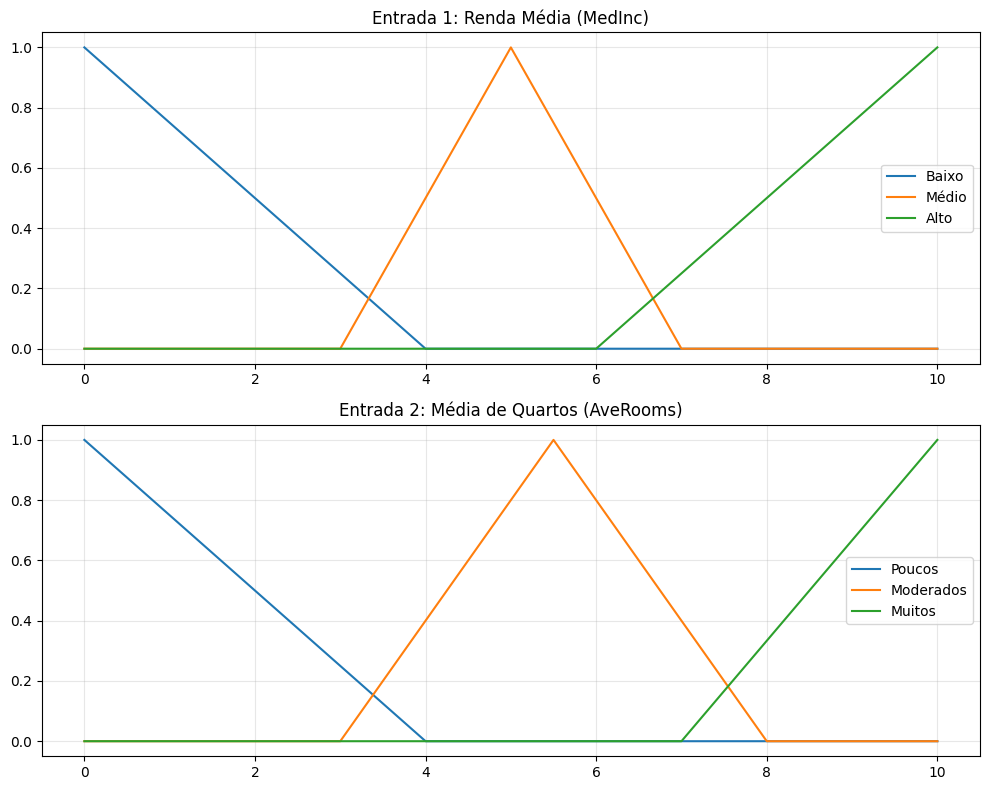

✅ Figura 1 gerada: Funções de Pertinência de Entrada.


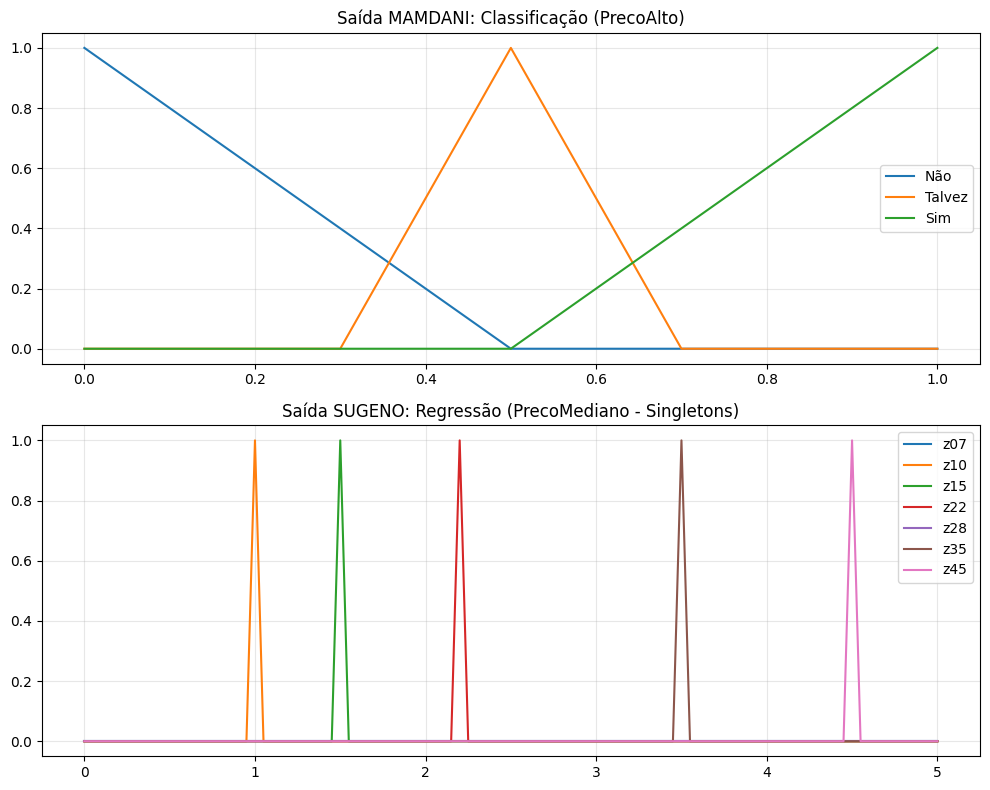

✅ Figura 2 gerada: Funções de Pertinência de Saída.
Gerando superfície 3D Mamdani...


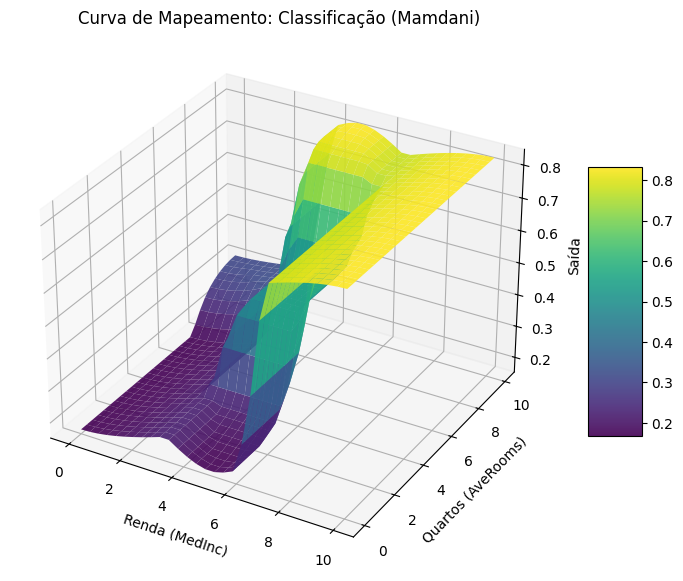

Gerando superfície 3D Sugeno...


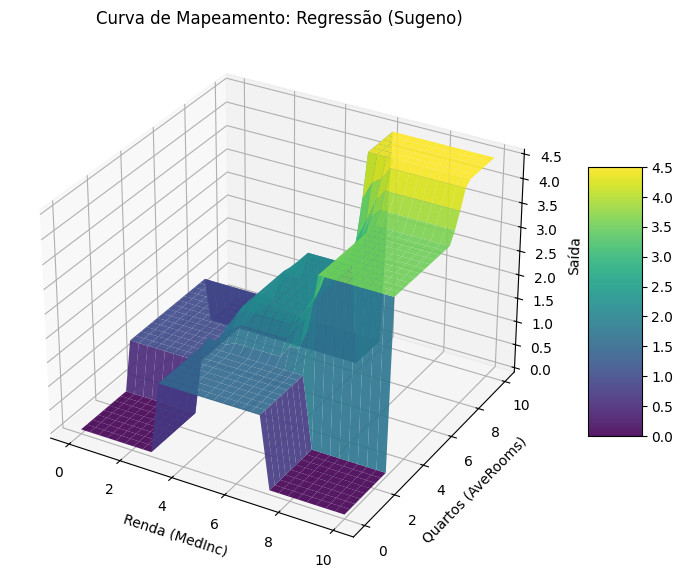

✅ Figuras 3 e 4 geradas: Curvas de Mapeamento.


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz

def visualizar_requisitos_fuzzy_corrigido():
    print("--- GERANDO FIGURAS PARA O RELATÓRIO ---")

    # ==========================================
    # 1. FUNÇÕES DE PERTINÊNCIA (ENTRADAS)
    # ==========================================
    # O segredo aqui é não criar a figure antes se o .view() for instável,
    # mas o método abaixo costuma ser o mais robusto:

    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 8))

    # Plot MedInc
    # Iteramos sobre os termos para garantir o plot manual se o .view falhar
    for label in MedInc.terms:
        ax0.plot(MedInc.universe, MedInc[label].mf, label=label)
    ax0.set_title('Entrada 1: Renda Média (MedInc)')
    ax0.legend()
    ax0.grid(True, alpha=0.3)

    # Plot AveRooms
    for label in AveRooms.terms:
        ax1.plot(AveRooms.universe, AveRooms[label].mf, label=label)
    ax1.set_title('Entrada 2: Média de Quartos (AveRooms)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("✅ Figura 1 gerada: Funções de Pertinência de Entrada.")

    # ==========================================
    # 2. FUNÇÕES DE PERTINÊNCIA (SAÍDAS)
    # ==========================================

    fig2, (ax2, ax3) = plt.subplots(nrows=2, figsize=(10, 8))

    # Saída Mamdani (Classificação)
    for label in var_out_clf.terms:
        ax2.plot(var_out_clf.universe, var_out_clf[label].mf, label=label)
    ax2.set_title('Saída MAMDANI: Classificação (PrecoAlto)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Saída Sugeno (Regressão - Singletons)
    for label in var_out_reg.terms:
        ax3.plot(var_out_reg.universe, var_out_reg[label].mf, label=label)
    ax3.set_title('Saída SUGENO: Regressão (PrecoMediano - Singletons)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("✅ Figura 2 gerada: Funções de Pertinência de Saída.")

    # ==========================================
    # 3. CURVA DE MAPEAMENTO (SUPERFÍCIE 3D)
    # ==========================================

    def plot_surface_manual(sistema, nome_saida, titulo):
        # Resolução reduzida para processamento rápido (30x30)
        x = np.linspace(0, 10, 30)
        y = np.linspace(0, 10, 30)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(30):
            for j in range(30):
                sistema.input['MedInc'] = X[i, j]
                sistema.input['AveRooms'] = Y[i, j]
                try:
                    sistema.compute()
                    Z[i, j] = sistema.output[nome_saida]
                except:
                    Z[i, j] = 0

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

        ax.set_xlabel('Renda (MedInc)')
        ax.set_ylabel('Quartos (AveRooms)')
        ax.set_zlabel('Saída')
        ax.set_title(titulo)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

    print("Gerando superfície 3D Mamdani...")
    plot_surface_manual(sis_clf, 'PrecoAlto_clf', 'Curva de Mapeamento: Classificação (Mamdani)')

    print("Gerando superfície 3D Sugeno...")
    plot_surface_manual(sis_reg, 'PrecoMediano_reg', 'Curva de Mapeamento: Regressão (Sugeno)')

    print("✅ Figuras 3 e 4 geradas: Curvas de Mapeamento.")

# Executar a correção
if __name__ == '__main__':
    # Certifique-se de ter rodado o script principal antes para ter as variáveis:
    # MedInc, AveRooms, var_out_clf, var_out_reg, sis_clf, sis_reg
    visualizar_requisitos_fuzzy_corrigido()